In [ ]:
import hdf5plugin, h5py, numpy as np, torch, random, glob, os, math, csv, json
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import imageio as imageio 
import unet

from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from datetime import datetime
from tqdm.auto import tqdm
from IPython.display import clear_output

In [121]:
target_paths = [
    "/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_109_HAADF_20_0.606_4_1.7_100_frame1_masked.tif"]

input_paths = [
    "/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_101_HAADF_20_0.606_0.2_1.7_100_frame1_masked.tif",
    "/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_103_HAADF_20_0.606_0.5_1.7_100_frame1_masked.tif",
    "/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_107_HAADF_20_0.606_2_1.7_100_frame1_masked.tif"
]

verification_path = ["/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_105_HAADF_20_0.606_1_1.7_100_frame1_masked.tif"]


EXTS = ("tif", "tiff", "png", "jpg", "jpeg")

# training
SEED = 69
EPOCHS = 100
BATCH_SIZE = 4
LR = 2e-4
WEIGHT_DECAY = 0.0

# patches
TRAIN_CROP = 512    
VAL_CROP   = 512

CLIP_NORM = 1.0

# dataset behaviour
NORM = "zscore"          # "mad" or "zscore"
AUGMENT = True
BIDIRECTIONAL = False
REPEATS_PER_IMAGE = 100  # makes more random crops per source frame
RESIDUAL_SCALE = 1.0

# loaders
NUM_WORKERS = 0 if __name__ == "__main__" else 0  # notebook: keep 0 to avoid issues
PIN_MEMORY = True

# device
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
model = unet.UDenoiseNet(nin=1, nf=64, base_width=11, top_width=3).to(DEVICE)


In [124]:
# import numpy as np
# import tifffile as tiff
# import matplotlib.pyplot as plt
# import os

# def lowpass_k_cutoff(img, cutoff_ratio=0.8):
#     assert img.ndim == 2, "Image must be 2D"

#     H, W = img.shape

#     # FFT
#     F = np.fft.fftshift(np.fft.fft2(img))

#     # Frequency grid
#     ky = np.fft.fftfreq(H)
#     kx = np.fft.fftfreq(W)
#     kx, ky = np.meshgrid(kx, ky)
#     k = np.sqrt(kx**2 + ky**2)
#     k = np.fft.fftshift(k)

#     k_max = k.max()

#     # Mask: keep low-k only
#     mask = (k <= cutoff_ratio * k_max)

#     F_filtered = F * mask
#     img_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real

#     return img_filtered, mask


target_paths = [
    "/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_109_HAADF_20_0.606_4_1.7_100_frame1_masked.tif"
]

input_paths = [
    "/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_101_HAADF_20_0.606_0.2_1.7_100_frame1_masked.tif",
    "/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_103_HAADF_20_0.606_0.5_1.7_100_frame1_masked.tif",
    "/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_107_HAADF_20_0.606_2_1.7_100_frame1_masked.tif"
]

# all_paths = input_paths + target_paths
# cutoff_ratio = 0.64

# for path in all_paths:
#     # Load image
#     img = tiff.imread(path).astype(np.float32)

#     # Apply filter
#     filtered_img, k_mask = lowpass_k_cutoff(img, cutoff_ratio=cutoff_ratio)

#     # Build output filename
#     base, ext = os.path.splitext(path)
#     out_path = f"{base}_masked{ext}"

#     # Save
#     tiff.imwrite(out_path, filtered_img.astype(np.float32))

#     print(f"Saved: {out_path}")

#     # Optional: show one example (comment out if not needed)
    
#     # plt.figure(figsize=(12,4))
#     # plt.subplot(1,3,1)
#     # plt.title("Original")
#     # plt.imshow(img, cmap="gray")
#     # plt.axis("off")

#     # plt.subplot(1,3,2)
#     # plt.title("k-space mask")
#     # plt.imshow(k_mask, cmap="gray")
#     # plt.axis("off")

#     # plt.subplot(1,3,3)
#     # plt.title(f"Filtered (|k| ≤ {cutoff_ratio} k_max)")
#     # plt.imshow(filtered_img, cmap="gray")
#     # plt.axis("off")
#     # plt.legend()
#     # plt.colorbar()

#     # plt.show()
    


/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_109_HAADF_20_0.606_4_1.7_100_frame1_masked.tif
  max value: -32768, count: 17

/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_101_HAADF_20_0.606_0.2_1.7_100_frame1_masked.tif
  max value: -32768, count: 23

/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_103_HAADF_20_0.606_0.5_1.7_100_frame1_masked.tif
  max value: -32768, count: 25

/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_107_HAADF_20_0.606_2_1.7_100_frame1_masked.tif
  max value: -32768, count: 18



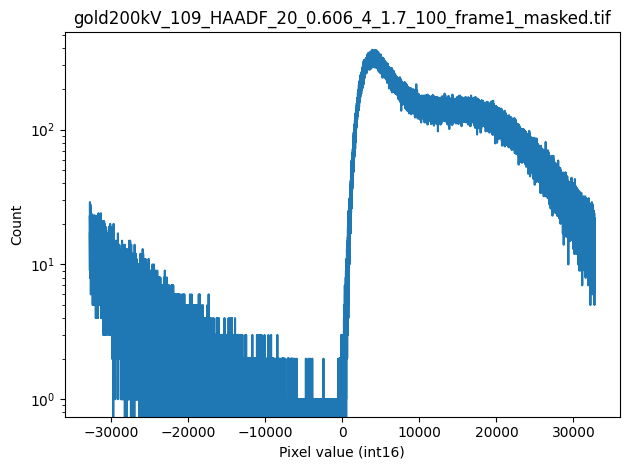

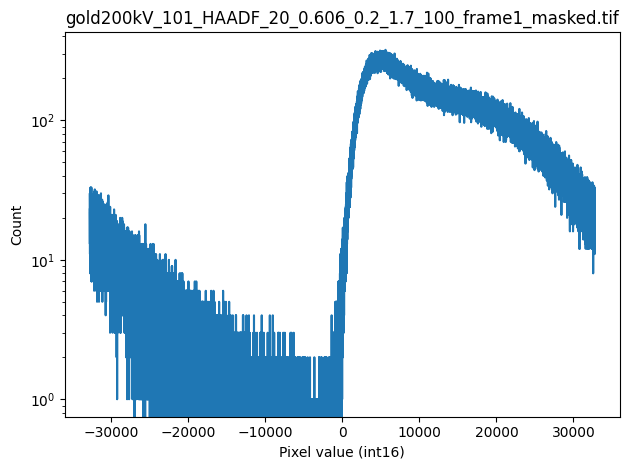

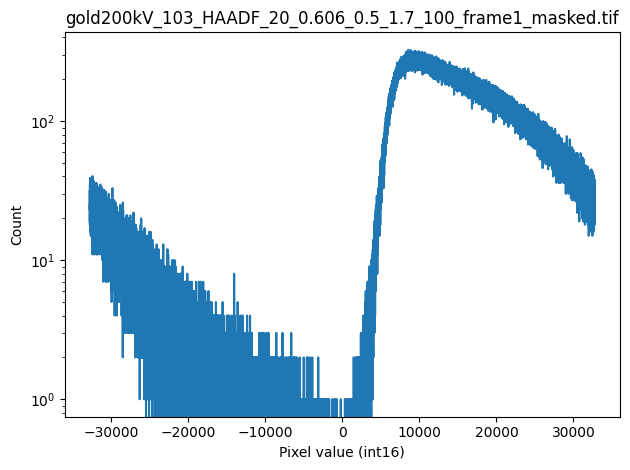

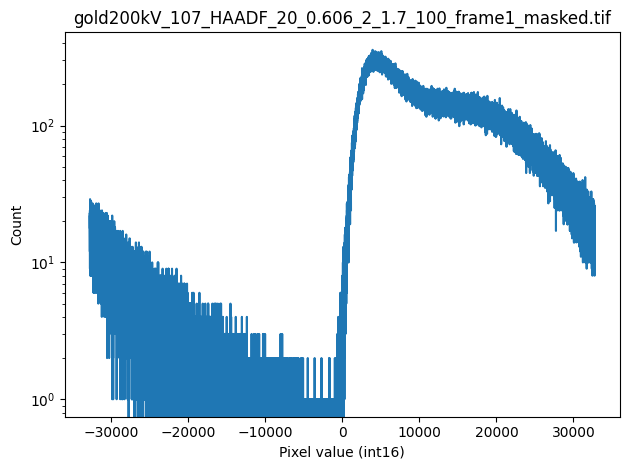

In [126]:
import numpy as np
import tifffile as tiff

def count_max_pixels(path):
    img = tiff.imread(path)

    # Ensure int16
    img = img.astype(np.int16, copy=False)

    max_val = img.min()
    count = np.sum(img == max_val)

    return max_val, count


# Process all paths
all_paths = target_paths + input_paths

for path in all_paths:
    max_val, count = count_max_pixels(path)
    print(f"{path}")
    print(f"  max value: {max_val}, count: {count}\n")

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from pathlib import Path

all_paths = target_paths + input_paths

for path in all_paths:
    img = tiff.imread(path).astype(np.int16, copy=False)

    # Full int16 range histogram
    counts, bins = np.histogram(
        img,
        bins=65536,
        range=(-32768, 32767)
    )

    plt.figure()
    plt.plot(bins[:-1], counts)
    plt.yscale("log")  # important for visibility
    plt.xlabel("Pixel value (int16)")
    plt.ylabel("Count")
    plt.title(Path(path).name)
    plt.tight_layout()
    plt.show()



In [127]:
BASE_DIRS = [
    r"/local/beestjtte/hackathon/golddata/Hackgold200kV",
    r"/local/beestjtte/hackathon/golddata/Hackgold60kV",
    r"/local/beestjtte/hackathon/golddata/Hackgold30kV",
]

def collect_tiffs(folder):
    return sorted(
        glob.glob(os.path.join(folder, "*.tif")) +
        glob.glob(os.path.join(folder, "*.tiff"))
    )

groups = {}
for d in BASE_DIRS:
    name = os.path.basename(d.rstrip("\\/"))
    paths = collect_tiffs(d)
    groups[name] = paths
    print(f"{name}: {len(paths)} TIFF frames")



Hackgold200kV: 0 TIFF frames
Hackgold60kV: 0 TIFF frames
Hackgold30kV: 0 TIFF frames


In [128]:
class TwoByTwoN2NDataset(Dataset):
    def __init__(self, input_paths, target_paths, crop=256, repeats=200,
                 augment=True, norm="zscore", cross=True, bidirectional=True):
        self.crop = int(crop)
        self.repeats = int(repeats)
        self.augment = bool(augment)
        self.norm = norm.lower()
        self.cross = bool(cross)
        self.bidirectional = bool(bidirectional)


        self.X = [self._load_and_norm(p) for p in input_paths]
        self.Y = [self._load_and_norm(p) for p in target_paths]

        H, W = self.X[0].shape
        for im in self.X + self.Y:
            if im.shape != (H, W):
                raise ValueError("All 4 images must have the same shape.")
        self.H, self.W = H, W

    def _load_and_norm(self, p):
        im = imageio.imread(p).astype(np.float32)
        if im.ndim == 3:
            im = im.mean(axis=-1)
        return self._mad(im) if self.norm == "mad" else self._zscore(im)

    @staticmethod
    def _mad(x, eps=1e-6):
        med = np.median(x)
        mad = np.median(np.abs(x - med)) + eps
        return (x - med) / (1.4826 * mad)

    @staticmethod
    def _zscore(x, eps=1e-6):
        m = float(x.mean()); s = max(float(x.std()), eps)
        return (x - m) / s

    def __len__(self):
        return self.repeats

    def __getitem__(self, idx):
        # choose which full images to use
        if self.cross:
            x_full = self.X[np.random.randint(0, len(self.X))]
            y_full = self.Y[np.random.randint(0, len(self.Y))]
        else:
            k = np.random.randint(0, 2)
            x_full = self.X[k]
            y_full = self.Y[k]

        intensity = -100
        while intensity < 0.2:
            # same crop location for both
            c = self.crop
            top = np.random.randint(0, self.H - c + 1)
            left = np.random.randint(0, self.W - c + 1)
            x = x_full[top:top+c, left:left+c].copy()
            y = y_full[top:top+c, left:left+c].copy()
            intensity = np.average(x)

        # augment (same transform on both)
        if self.augment:
            if random.random() < 0.5:
                x = np.flip(x, 0); y = np.flip(y, 0)
            if random.random() < 0.5:
                x = np.flip(x, 1); y = np.flip(y, 1)
            k = random.randint(0, 3)
            if k:
                x = np.rot90(x, k).copy()
                y = np.rot90(y, k).copy()

        # optional swap direction
        if self.bidirectional and random.random() < 0.5:
            x, y = y, x

        x = torch.from_numpy(x.copy()).unsqueeze(0).float()
        y = torch.from_numpy(y.copy()).unsqueeze(0).float()

        return x, y


In [129]:
train_ds = TwoByTwoN2NDataset(
    input_paths, target_paths,
    crop=128,
    repeats=10_000,
    augment=True,
    norm="zscore",
    cross=True,
    bidirectional=False,
)

val_ds = TwoByTwoN2NDataset(
    input_paths, target_paths,
    crop=128,
    repeats=256,          # small but enough for smooth val loss
    augment=False,        # IMPORTANT
    norm="zscore",
    cross=True,
    bidirectional=False,  # keep direction fixed for stability
)

train_loader = DataLoader(
    train_ds,
    batch_size=768,
    shuffle=True,
    num_workers=0,        # IMPORTANT
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=768,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print(f"Loaders ready → train {len(train_ds)} | val {len(val_ds)}")

Loaders ready → train 10000 | val 256


/tmp/ipykernel_1997342/899886972.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(p).astype(np.float32)


In [130]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-4
)

criterion = nn.L1Loss()  # assuming you defined it earlier

scaler = GradScaler(enabled=torch.cuda.is_available())

print('Number of patches in total: ', len(train_ds)*EPOCHS,
      ', with batch size ', train_loader.batch_size)

Number of patches in total:  1000000 , with batch size  768


In [131]:
def apply_model(model, x, model_name, residual_scale=1.0):
    if model_name == "UDenoiseNet":
        noise = model(x)
        return x - residual_scale * noise
    else:
        return model(x)  # or your other branches


#Topaz-style SNR from correlation
def corrcoef_per_sample(a, b, eps=1e-8):
    """
    Pearson correlation coefficient per sample.
    a,b: tensors (N,1,H,W) or (N,H,W).
    Returns: tensor (N,) of corr coefficients in [-1,1].
    """
    if a.dim() == 4: a = a.squeeze(1) #remove channel dim if present
    if b.dim() == 4: b = b.squeeze(1)
    N = a.shape[0]
    a = a.view(N, -1)
    b = b.view(N, -1)
    a = a - a.mean(dim=1, keepdim=True)
    b = b - b.mean(dim=1, keepdim=True)
    num = (a * b).mean(dim=1)
    den = a.std(dim=1) * b.std(dim=1) + eps
    p = num / den
    return p

def corr_snr_db_batch(denoised, raw_other_half, eps=1e-6):
    """
    Compute Topaz SNR_dB per sample and return batch average.
    SNR_dB = 10*log10(p/(1-p)), with p in (0,1).
    We clamp p to [eps, 1-eps] for numerical stability.
    """
    p = corrcoef_per_sample(denoised, raw_other_half)
    p = p.clamp(min=eps, max=1.0 - eps)     # avoid <=0 and >=1
    snr_db = 10.0 * torch.log10(p / (1.0 - p))
    return snr_db.mean().item()


#Exponential Moving Average (EMA) helper class
class EMA: 
    def __init__(self, model, decay=0.999):
        #Copy of parameters (no grads)
        self.shadow = {k: v.detach().clone() for k, v in model.state_dict().items()}
        self.decay = decay

    @torch.no_grad()
    def update(self, model):
        #Calculate and apply EMA
        for k, v in model.state_dict().items():
            self.shadow[k].mul_(self.decay).add_(v, alpha=1.0 - self.decay)

    @torch.no_grad()
    def load_ema(self, model):
        #Load EMA weights into model for evaluation
        model.load_state_dict(self.shadow, strict=True)


#Instantiate EMA
ema = EMA(model, decay=0.999)


#Number of steps per epoch
def steps_per_epoch(loader):
    n = len(loader.dataset)
    bs = loader.batch_size or 1
    return math.ceil(n / bs)

# ### Function that runs every epoch, be it train or evaluation

In [132]:
train_hist, val_hist, snr_hist = [], [], []

def run_epoch(loader, train=True):
    total, count = 0.0, 0

    if train:
        model.train()
        pbar = tqdm(loader, desc="Train", leave=False, dynamic_ncols=True)
        for x, y in pbar:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with autocast('cuda', enabled=torch.cuda.is_available()):
                # Noise2Noise: latent is denoised estimate (depends on model type)
                latent = apply_model(model, x, "UDenoiseNet", residual_scale=1.0)
                loss = criterion(torch.log(torch.abs(torch.fft.fftshift(torch.fft.fft2(latent)))+1), torch.log(torch.abs(torch.fft.fftshift(torch.fft.fft2(y)))+1))


            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()

            ema.update(model)

            bs = x.size(0)
            total += float(loss.item()) * bs
            count += bs

            pbar.set_postfix(loss=f"{(total / max(1, count)):.6f}")

        return total / max(1, count)

    else:
        model.eval()
        saved_state = model.state_dict()
        ema.load_ema(model)

        total_snr_db = 0.0
        n_batches = 0
        total_loss = 0.0
        count = 0

        with torch.inference_mode(), autocast('cuda', enabled=torch.cuda.is_available()):
            pbar = tqdm(loader, desc="Validation", leave=False, dynamic_ncols=True)
            for x, y in pbar:
                x = x.to(DEVICE, non_blocking=True)
                y = y.to(DEVICE, non_blocking=True)

                latent = apply_model(model, x, "UDenoiseNet", residual_scale=1.0)
                loss = criterion(latent, y)


                bs = x.size(0)
                total_loss += float(loss.item()) * bs
                count += bs

                # use latent vs y for SNR (as you did before)
                total_snr_db += corr_snr_db_batch(latent.float(), y.float())
                n_batches += 1

                pbar.set_postfix(val_loss=f"{(total_loss / max(1, count)):.6f}")

        model.load_state_dict(saved_state, strict=True)

        val_loss = total_loss / max(1, count)
        val_snr_db = total_snr_db / max(1, n_batches)
        return val_loss, val_snr_db


In [133]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = os.path.join("runs", timestamp)

os.makedirs(RUN_DIR, exist_ok=True)
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")
PLOT_DIR = os.path.join(RUN_DIR, "plots")

os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

LOG_PATH = os.path.join(RUN_DIR, "metrics.csv")

with open(LOG_PATH, "w", newline="") as f:
    csv.writer(f).writerow(["epoch", "train_loss", "val_loss", "val_snr_db"])

print(f"Run directory: {RUN_DIR}")

#Make a small config file for future reference
# config = {
#     # core run identity
#     "timestamp": timestamp,
#     "run_dir": RUN_DIR,

#     # dataset + split
#     "base_dir": BASE_DIR,
#     "train_crop": train_crop,
#     "val_crop": validation_crop,
#     "train_repeats": train_repeats,
#     "val_repeats": validation_repeats,

#     # model choice
#     "model_name": MODEL_NAME,

#     # training hyperparams
#     "epochs": EPOCHS,
#     "seed": chosen_seed,
#     "clip_norm": CLIP_NORM,
#     "plot_interval": plot_interval,

#     # device / runtime
#     "device": device,

#     # (optional but useful) store raw CLI args too
#     "args": vars(args),
# }


# with open(os.path.join(RUN_DIR, "config.json"), "w") as f:
#     json.dump(config, f, indent=2)

# with open(os.path.join(RUN_DIR, "dataset_split.json"), "w") as f:
#     json.dump(split_info, f, indent=2)

Run directory: runs/2025-12-18_14-19-01


In [134]:
#training loop
best_val = float("inf")
sp_train = steps_per_epoch(train_loader)
total_iters = sp_train * EPOCHS
global_step = 0
plot_interval = max(1, EPOCHS // 10)


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs"):
    train_loss = run_epoch(train_loader, train=True)
    global_step += sp_train

    val_loss, val_snr_db = run_epoch(val_loader, train=False)

    scheduler.step() 

    print(f"Epoch {epoch:03d}/{EPOCHS} "
          f"| steps (this epoch): {sp_train} "
          f"| global steps: {global_step}/{total_iters} "
          f"| train {train_loss:.6f} | val(EMA) {val_loss:.6f} "
          f"| SNR {val_snr_db:.2f} dB")
    
    # Update histories + live plot (once per epoch)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    snr_hist.append(val_snr_db)

    with open(LOG_PATH, "a", newline="") as f:
        csv.writer(f).writerow([epoch, train_loss, val_loss, val_snr_db])


    # save best (EMA) checkpoint
    if val_loss < best_val:
        best_val = val_loss
        torch.save(
            {   "epoch": epoch,
                # weights
                "ema": ema.shadow,                  # use for inference
                "model_live": model.state_dict(),   # optional
                "optimizer": optimizer.state_dict(),
                # metrics
                "val_loss": val_loss,
                "val_snr_db": val_snr_db,
                # embed full run config
                "config": {
                    # **config,  # includes model_name, base_dir, crop, seed, etc.
                    "batch_size": train_loader.batch_size,
                    "optimizer_name": optimizer.__class__.__name__,
                    "lr": optimizer.param_groups[0]["lr"],
                    "norm": getattr(train_ds, "norm", None),
                    "repeats_per_image": getattr(train_ds, "repeats_per_image", None),
                },
            },
            os.path.join(CKPT_DIR, f"best_{timestamp}.pt"),
        )

    #Periodic plots (every 10% of total epochs and last epoch)
    if (epoch % plot_interval == 0) or (epoch == EPOCHS):
        epochs_so_far = range(1, len(train_hist) + 1)

        fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

        # ---- Loss subplot ----
        ax = axes[0]
        ax.plot(epochs_so_far, train_hist, label="train loss")
        ax.plot(epochs_so_far, val_hist,   label="val loss")
        ax.set_ylabel("Loss")
        ax.set_xlim(1, EPOCHS)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # ---- SNR subplot ----
        ax = axes[1]
        ax.plot(epochs_so_far, snr_hist, label="val SNR (dB)")
        ax.set_ylabel("SNR (dB)")
        ax.set_xlabel("Epoch")
        ax.set_xlim(1, EPOCHS)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # save combined figure
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, f"Loss_SNR{epoch:03d}.png"))
        plt.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 001/100 | steps (this epoch): 14 | global steps: 14/1400 | train 0.661429 | val(EMA) 0.982404 | SNR -11.70 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 002/100 | steps (this epoch): 14 | global steps: 28/1400 | train 0.657552 | val(EMA) 0.989549 | SNR -13.59 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 003/100 | steps (this epoch): 14 | global steps: 42/1400 | train 0.658391 | val(EMA) 0.957023 | SNR -12.62 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 004/100 | steps (this epoch): 14 | global steps: 56/1400 | train 0.655948 | val(EMA) 0.967243 | SNR -10.22 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 005/100 | steps (this epoch): 14 | global steps: 70/1400 | train 0.659915 | val(EMA) 0.944719 | SNR -12.61 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 006/100 | steps (this epoch): 14 | global steps: 84/1400 | train 0.656362 | val(EMA) 0.964191 | SNR -10.42 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 007/100 | steps (this epoch): 14 | global steps: 98/1400 | train 0.655145 | val(EMA) 0.973405 | SNR -11.48 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 008/100 | steps (this epoch): 14 | global steps: 112/1400 | train 0.657723 | val(EMA) 0.971804 | SNR -12.21 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 009/100 | steps (this epoch): 14 | global steps: 126/1400 | train 0.653307 | val(EMA) 0.965278 | SNR -13.11 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 010/100 | steps (this epoch): 14 | global steps: 140/1400 | train 0.656915 | val(EMA) 0.993497 | SNR -12.53 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 011/100 | steps (this epoch): 14 | global steps: 154/1400 | train 0.655365 | val(EMA) 0.945037 | SNR -10.85 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 012/100 | steps (this epoch): 14 | global steps: 168/1400 | train 0.657082 | val(EMA) 0.994016 | SNR -11.80 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 013/100 | steps (this epoch): 14 | global steps: 182/1400 | train 0.652974 | val(EMA) 0.957593 | SNR -8.73 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 014/100 | steps (this epoch): 14 | global steps: 196/1400 | train 0.653464 | val(EMA) 0.980954 | SNR -15.09 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 015/100 | steps (this epoch): 14 | global steps: 210/1400 | train 0.654165 | val(EMA) 0.961302 | SNR -12.60 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 016/100 | steps (this epoch): 14 | global steps: 224/1400 | train 0.655894 | val(EMA) 0.986053 | SNR -12.03 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 017/100 | steps (this epoch): 14 | global steps: 238/1400 | train 0.653077 | val(EMA) 0.968137 | SNR -11.78 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 018/100 | steps (this epoch): 14 | global steps: 252/1400 | train 0.653058 | val(EMA) 0.961771 | SNR -11.01 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 019/100 | steps (this epoch): 14 | global steps: 266/1400 | train 0.651504 | val(EMA) 0.986774 | SNR -13.55 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 020/100 | steps (this epoch): 14 | global steps: 280/1400 | train 0.652920 | val(EMA) 0.980238 | SNR -13.20 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 021/100 | steps (this epoch): 14 | global steps: 294/1400 | train 0.651183 | val(EMA) 0.975940 | SNR -12.11 dB


Train:   0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [135]:
verification_path = '/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_105_HAADF_20_0.606_1_1.7_100_frame1_masked.tiff'
CKPT_DIR = '/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/runs/2025-12-18_14-19-01/checkpoints/best_2025-12-18_14-19-01.pt'
checkpoint = torch.load(CKPT_DIR, map_location=DEVICE)
print(checkpoint.keys())

dict_keys(['epoch', 'ema', 'model_live', 'optimizer', 'val_loss', 'val_snr_db', 'config'])


In [ ]:
# verification_path = '/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_105_HAADF_20_0.606_1_1.7_100_frame1_masked.tiff'
# CKPT_DIR = '/home/wdekleijne/WillemhackSTEM/WillemhackSTEM/runs/2025-12-18_14-19-01/checkpoints/best_2025-12-18_14-19-01.pt'
# checkpoint = torch.load(CKPT_DIR, map_location=DEVICE)
# print(checkpoint.keys())

In [136]:
model.load_state_dict(checkpoint['ema'], strict=True)
model.eval()
with torch.inference_mode():
    im = imageio.imread(verification_path).astype(np.int16)
    if im.ndim == 3:
        im = im.mean(axis=-1)
    im_norm = (im - im.mean()) / (im.std() + 1e-6)
    x = torch.from_numpy(im_norm.copy()).unsqueeze(0).unsqueeze(0).float().to(DEVICE)

    denoised = apply_model(model, x, "UDenoiseNet", residual_scale=1.0)
    denoised = denoised.squeeze().cpu().numpy()

    # Denormalize
    denoised_denorm = denoised * (im.std() + 1e-6) + im.mean()

    # Save denoised image
    output_path = verification_path.replace(".tiff", "_denoised.tiff")
    imageio.imwrite(output_path, denoised_denorm.astype(np.int16))
    print(f"Denoised image saved to: {output_path}")

/tmp/ipykernel_1997342/3733468220.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(verification_path).astype(np.int16)


Denoised image saved to: /home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_105_HAADF_20_0.606_1_1.7_100_frame1_masked_denoised.tiff


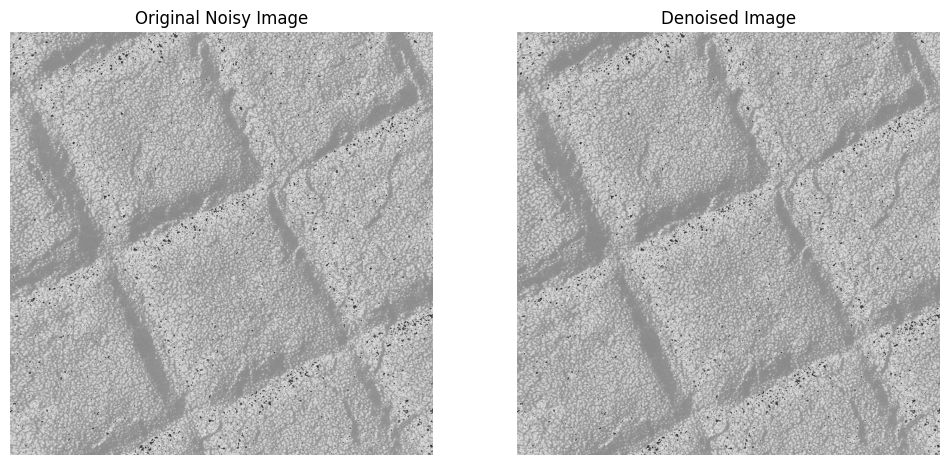

In [137]:
#show denoised image
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Original Noisy Image')
plt.imshow(im, cmap='gray')
plt.axis('off') 
# add the denoised image plot
plt.subplot(1,2,2)
plt.title('Denoised Image')
plt.imshow(denoised_denorm, cmap='gray')
plt.axis('off') 
plt.show()

In [148]:
import numpy as np
import torch
import imageio

def denoise_patched(
    model,
    image,
    patch_size=128,
    overlap=32,
    device="cuda",
):
    """
    image: 2D numpy array (float32, z-scored)
    returns: denoised image (float32, z-scored)
    """

    H, W = image.shape
    stride = patch_size - overlap

    out = np.zeros((H, W), dtype=np.float32)
    weight = np.zeros((H, W), dtype=np.float32)

    model.eval()
    with torch.inference_mode():
        for top in range(0, H - patch_size + 1, stride):
            for left in range(0, W - patch_size + 1, stride):

                patch = image[top:top+patch_size, left:left+patch_size]

                x = (
                    torch.from_numpy(patch)
                    .unsqueeze(0)
                    .unsqueeze(0)
                    .float()
                    .to(device)
                )

                y = apply_model(
                    model,
                    x,
                    "UDenoiseNet",
                    residual_scale=1.0,
                )

                y = y.squeeze().cpu().numpy()

                out[top:top+patch_size, left:left+patch_size] += y
                weight[top:top+patch_size, left:left+patch_size] += 1.0

    return out / np.maximum(weight, 1e-6)


In [149]:
model.load_state_dict(checkpoint["ema"], strict=True)
model.eval()

# Load image
im = imageio.imread(verification_path).astype(np.float32)
if im.ndim == 3:
    im = im.mean(axis=-1)

# SAME normalization as training
mean = im.mean()
std = im.std() + 1e-6
im_norm = (im - mean) / std

# Patch-based denoising
denoised_norm = denoise_patched(
    model,
    im_norm,
    patch_size=128,
    overlap=32,       # recommended
    device=DEVICE,
)

# De-normalize
denoised = denoised_norm * std + mean

# Save
output_path = verification_path.replace(".tiff", "_denoised.tiff")
imageio.imwrite(output_path, denoised.astype(np.int16))
output_path = verification_path.replace(".tiff", "_tiffwrite.tiff")
tiff.imwrite(output_path, denoised.astype(np.float32))
print(f"Denoised image saved to: {output_path}")



/tmp/ipykernel_1997342/328478883.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(verification_path).astype(np.float32)


Denoised image saved to: /home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_105_HAADF_20_0.606_1_1.7_100_frame1_masked_tiffwrite.tiff


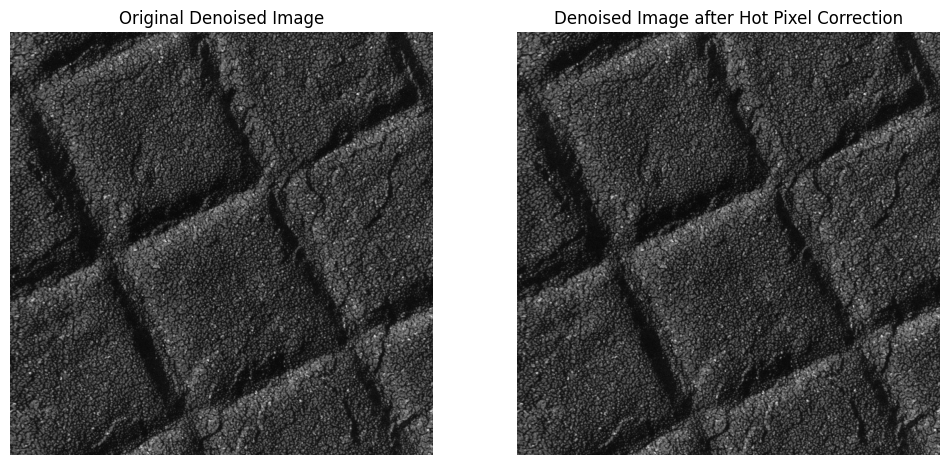

In [150]:
import numpy as np

def replace_hot_pixels(img, threshold=64000.0):
    """
    Replace pixels > threshold with mean of 4-connected neighbors.

    img: 2D numpy array (float32)
    returns: corrected copy
    """
    assert img.ndim == 2

    out = img.copy()

    # Mask of hot pixels (exclude borders)
    hot = img > threshold
    hot[0, :] = hot[-1, :] = False
    hot[:, 0] = hot[:, -1] = False

    # 4-neighbor average (computed from ORIGINAL img)
    avg4 = (
        img[:-2, 1:-1] +  # up
        img[2:,  1:-1] +  # down
        img[1:-1, :-2] +  # left
        img[1:-1, 2:]     # right
    ) * 0.25

    # Replace
    out[1:-1, 1:-1][hot[1:-1, 1:-1]] = avg4[hot[1:-1, 1:-1]]

    return out

#showoutput image side to side to output image after hot pixel correction
corrected = replace_hot_pixels(denoised, threshold=64000.0)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Original Denoised Image')
plt.imshow(denoised, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Denoised Image after Hot Pixel Correction')
plt.imshow(corrected, cmap='gray')
plt.axis('off')

plt.show()

In [151]:
output_path = verification_path.replace(".tiff", "_tiffwritewhitecorrect.tiff")
tiff.imwrite(output_path, corrected.astype(np.float32))
print(f"Denoised image saved to: {output_path}")

Denoised image saved to: /home/wdekleijne/WillemhackSTEM/WillemhackSTEM/gold200kV_105_HAADF_20_0.606_1_1.7_100_frame1_masked_tiffwritewhitecorrect.tiff
